## Ensemble

Using rotated to hz + OpenCv border

Basic default transforms

Densenet

at bs=32 only using 1.8GB

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
import geopandas as gpd
from resizeimage import resizeimage
import datetime
import uuid
from torchvision.models import densenet121
from fastai_extensions import *

In [3]:
torch.cuda.set_device(2)
torch.cuda.current_device()

2

In [4]:
data_dir = Path('data')
colombia_rural = Path('data/stac/colombia/borde_rural')
colombia_soacha = Path('data/stac/colombia/borde_soacha')

In [5]:
guatemala_mixco1 = Path('data/stac/guatemala/mixco_1_and_ebenezer')
guatemala_mixco3 = Path('data/stac/guatemala/mixco_3')

In [6]:
st_lucia_castries = Path('data/stac/st_lucia/castries')
st_lucia_dennery = Path('data/stac/st_lucia/dennery')
st_lucia_gros_islet = Path('data/stac/st_lucia/gros_islet')

In [7]:
COUNTRY='colombia'
REGION='borde_rural'
DATASET = f'{COUNTRY}_{REGION}'
DATASET_PATH=colombia_rural
path=data_dir/f'{COUNTRY}_{REGION}/cropped/'
TRAIN_JSON = f'train-{REGION}.geojson'
TEST_JSON = f'test-{REGION}.geojson'

In [8]:
RETRAIN = True
RESIZE_IMAGES = True

In [9]:
MODEL_NAME='cv_reflect_101_ensemble'

In [10]:
NB_NUM='07_1'

In [11]:
DATE = datetime.datetime.today().strftime('%Y%m%d')
UID=str(uuid.uuid4())[:8]
print(f'UID: {UID}, DATE: {DATE}')                                                 

UID: ec244e15, DATE: 20191102


In [12]:
#DATE = '20191031'
#UID = 'd3611e57'

In [13]:
SUB_NUM='10'

In [14]:
img_size=256
bs=32

In [15]:
train_images=data_dir/f'train/rotated/clipped/{img_size}'
test_images=data_dir/f'test/rotated/clipped/{img_size}'

In [16]:
df_all=pd.read_csv(data_dir/'df_train_all.csv')

In [17]:
df_all.tail()

,id,roof_material,verified,country,region
22548,7a22ddec,healthy_metal,False,st_lucia,gros_islet
22549,7a2f73ea,healthy_metal,False,st_lucia,gros_islet
22550,7a34ffa4,healthy_metal,False,st_lucia,gros_islet
22551,7a41560a,healthy_metal,False,st_lucia,gros_islet
22552,7a283ad0,healthy_metal,False,st_lucia,gros_islet


In [18]:
df_test=pd.read_csv(data_dir/'df_test_all.csv')

In [19]:
df_test.tail()

,id,country,region
7320,7a4f3ff4,st_lucia,dennery
7321,7a4fc578,st_lucia,dennery
7322,7a4ac7b2,st_lucia,dennery
7323,7a47e25e,st_lucia,dennery
7324,7a4e3f78,st_lucia,dennery


In [20]:
df_all.loc[df_all['id'] == '7a204ec4']

,id,roof_material,verified,country,region
12960,7a204ec4,irregular_metal,True,guatemala,mixco_1_and_ebenezer


In [21]:
len(df_all)

22553

To put this in a `DataBunch` while using the [data block API](https://docs.fast.ai/data_block.html), we then need to using `ImageList` (and not `ImageDataBunch`). This will make sure the model created has the proper loss function to deal with the multiple classes.

In [22]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

### setup dataset

In [23]:
np.random.seed(42)
dep_var='roof_material'
src = (ImageList.from_df(path=train_images, df=df_all, cols='id', suffix='.tif')
       .split_by_rand_pct(0.2)
      .label_from_df(cols=dep_var)
      .add_test_folder(test_images))

In [24]:
data = (src.transform(tfms, size=128)
        .databunch(bs=bs).normalize(imagenet_stats))

In [25]:
#to check what params object has
#dir(data)

In [26]:
data.label_list

LabelLists;

Train: LabelList (18043 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
concrete_cement,irregular_metal,healthy_metal,healthy_metal,healthy_metal
Path: data/train/rotated/clipped/256;

Valid: LabelList (4510 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
irregular_metal,healthy_metal,healthy_metal,irregular_metal,healthy_metal
Path: data/train/rotated/clipped/256;

Test: LabelList (0 items)
x: ImageList

y: EmptyLabelList

Path: data/train/rotated/clipped/256

In [27]:
data.loss_func

FlattenedLoss of CrossEntropyLoss()

`show_batch` still works, and show us the different labels separated by `;`.

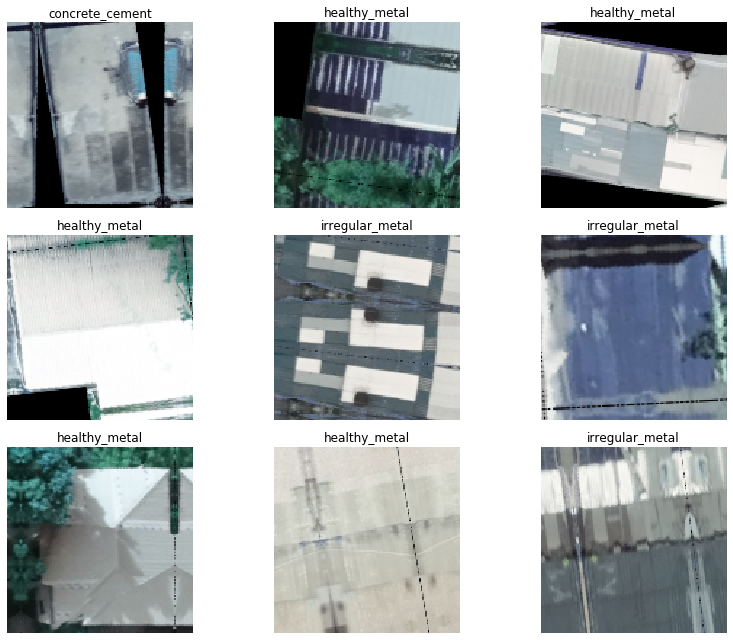

In [28]:
data.show_batch(rows=3, figsize=(12,9))

In [29]:
class LayerActivations():
    features=[]
    
    def __init__(self,model):
        self.features = []
        self.hook = model.register_forward_hook(self.hook_fn)
    
    def hook_fn(self,module,input,output):
        #out = F.avg_pool2d(output, kernel_size=8)
        self.features.extend(output.view(output.size(0),-1).cpu().data)

    
    def remove(self):
        
        self.hook.remove()

### Model

In [30]:
arch1 = densenet121
arch1_name = 'dn121'

In [33]:
arch.features

AttributeError: 'function' object has no attribute 'features'

In [39]:
#FP16

In [ ]:
def multi_fit(epochs:int, learn:MultiLearner, callbacks:Optional[CallbackList]=None, metrics:OptMetrics=None)->None:
    "Fit the `model` on `data` and learn using `loss_func` and `opt`."
    assert len(learn.data.train_dl) != 0, f"""Your training dataloader is empty, can't train a model.
        Use a smaller batch size (batch size={learn.data.train_dl.batch_size} for {len(learn.data.train_dl.dataset)} elements)."""
    cb_handler = CallbackHandler(callbacks, metrics)
    pbar = master_bar(range(epochs))
    cb_handler.on_train_begin(epochs, pbar=pbar, metrics=metrics)

    exception=False
    try:
        for epoch in pbar:
            learn.model.train()
            cb_handler.set_dl(learn.data.train_dl)
            cb_handler.on_epoch_begin()
            for xb,yb in progress_bar(learn.data.train_dl, parent=pbar):
                xb, yb = cb_handler.on_batch_begin(xb, yb)
                multi_loss_batch(learn.models, xb, yb, learn.loss_func, learn.opt, cb_handler)

                if cb_handler.on_batch_end(loss): 
                    break

            if not cb_handler.skip_validate and not learn.data.empty_val:
                val_loss = validate(learn.model, learn.data.valid_dl, loss_func=learn.loss_func,
                                       cb_handler=cb_handler, pbar=pbar)
            else: 
                val_loss=None
            if cb_handler.on_epoch_end(val_loss): 
                break
    except Exception as e:
        exception = e
        raise
    finally: 
        cb_handler.on_train_end(exception)

In [ ]:
class MultiLearner():
    "Trainer for `model` using `data` to minimize `loss_func` with optimizer `opt_func`."
    data:DataBunch
    model:nn.Module
    models:list
    opt_func:Callable=AdamW
    loss_func:Callable=None
    metrics:Collection[Callable]=None
    true_wd:bool=True
    bn_wd:bool=True
    wd:Floats=defaults.wd
    train_bn:bool=True
    path:str = None
    model_dir:PathOrStr = 'models'
    callback_fns:Collection[Callable]=None
    callbacks:Collection[Callback]=field(default_factory=list)
    layer_groups:Collection[nn.Module]=None
    add_time:bool=True
    silent:bool=None
    def __post_init__(self)->None:
        "Setup path,metrics, callbacks and ensure model directory exists."
        self.path = Path(ifnone(self.path, self.data.path))
        self.model = self.model.to(self.data.device)
        self.loss_func = self.loss_func or self.data.loss_func
        self.metrics=listify(self.metrics)
        if not self.layer_groups: self.layer_groups = [nn.Sequential(*flatten_model(self.model))]
        self.callbacks = listify(self.callbacks)
        if self.silent is None: self.silent = defaults.silent
        self.callback_fns = [partial(Recorder, add_time=self.add_time, silent=self.silent)] + listify(self.callback_fns)
        if defaults.extra_callbacks is not None: self.callbacks += defaults.extra_callbacks

    def init(self, init): 
        apply_init(self.model, init)

    def _test_writeable_path(self):
        path = self.path/self.model_dir
        try:
            path.mkdir(parents=True, exist_ok=True)
            tmp_file = get_tmp_file(path)
        except OSError as e:
            raise Exception(f"{e}\nCan't write to '{path}', set `learn.model_dir` attribute in Learner to a full libpath path that is writable") from None
        os.remove(tmp_file)

    def lr_range(self, lr:Union[float,slice])->np.ndarray:
        "Build differential learning rates from `lr`."
        if not isinstance(lr,slice): return lr
        if lr.start: 
            res = even_mults(lr.start, lr.stop, len(self.layer_groups))
        else: 
            res = [lr.stop/10]*(len(self.layer_groups)-1) + [lr.stop]
        return np.array(res)

    def fit(self, epochs:int, lr:Union[Floats,slice]=defaults.lr,
            wd:Floats=None, callbacks:Collection[Callback]=None)->None:
        "Fit the model on this learner with `lr` learning rate, `wd` weight decay for `epochs` with `callbacks`."
        lr = self.lr_range(lr)
        if wd is None: wd = self.wd
        if not getattr(self, 'opt', False): 
            self.create_opt(lr, wd)
        else: 
            self.opt.lr,self.opt.wd = lr,wd
        callbacks = [cb(self) for cb in self.callback_fns + listify(defaults.extra_callback_fns)] + listify(callbacks)
        multi_fit(epochs, self, metrics=self.metrics, callbacks=self.callbacks+callbacks)

    def create_opt(self, lr:Floats, wd:Floats=0.)->None:
        "Create optimizer with `lr` learning rate and `wd` weight decay."
        self.opt = OptimWrapper.create(self.opt_func, lr, self.layer_groups, wd=wd, true_wd=self.true_wd, bn_wd=self.bn_wd)

    def split(self, split_on:SplitFuncOrIdxList)->None:
        "Split the model at `split_on`."
        if isinstance(split_on,Callable): 
            split_on = split_on(self.model)
        self.layer_groups = split_model(self.model, split_on)
        return self

    def freeze_to(self, n:int)->None:
        "Freeze layers up to layer group `n`."
        for g in self.layer_groups[:n]:
            for l in g:
                if not self.train_bn or not isinstance(l, bn_types): requires_grad(l, False)
        for g in self.layer_groups[n:]: requires_grad(g, True)
        self.create_opt(defaults.lr)

    def freeze(self)->None:
        "Freeze up to last layer group."
        assert(len(self.layer_groups)>1)
        self.freeze_to(-1)

    def unfreeze(self):
        "Unfreeze entire model."
        self.freeze_to(0)

    def export(self, file:PathLikeOrBinaryStream='export.pkl', destroy=False):
        "Export the state of the `Learner` in `self.path/file`. `file` can be file-like (file or buffer)"
        if rank_distrib(): return # don't save if slave proc
        args = ['opt_func', 'loss_func', 'metrics', 'true_wd', 'bn_wd', 'wd', 'train_bn', 'model_dir', 'callback_fns']
        state = {a:getattr(self,a) for a in args}
        state['cb_state'] = {cb.__class__:cb.get_state() for cb in self.callbacks}
        #layer_groups -> need to find a way
        #TO SEE: do we save model structure and weights separately?
        with ModelOnCPU(self.model) as m:
            state['model'] = m
            xtra = dict(normalize=self.data.norm.keywords) if getattr(self.data, 'norm', False) else {}
            state['data'] = self.data.valid_ds.get_state(**xtra)
            state['cls'] = self.__class__
            try_save(state, self.path, file)
        if destroy: self.destroy()

    def save(self, file:PathLikeOrBinaryStream=None, return_path:bool=False, with_opt:bool=True):
        "Save model and optimizer state (if `with_opt`) with `file` to `self.model_dir`. `file` can be file-like (file or buffer)"
        if is_pathlike(file): self._test_writeable_path()
        if rank_distrib(): return # don't save if slave proc
        target = self.path/self.model_dir/f'{file}.pth' if is_pathlike(file) else file
        if not hasattr(self, 'opt'): 
            with_opt=False
        if not with_opt: 
            state = get_model(self.model).state_dict()
        else: 
            state = {'model': get_model(self.model).state_dict(), 'opt':self.opt.state_dict()}
        torch.save(state, target)
        if return_path: return target

    def dl(self, ds_type:DatasetType=DatasetType.Valid):
        "Return DataLoader for DatasetType `ds_type`."
        return self.data.dl(ds_type)

    def load(self, file:PathLikeOrBinaryStream=None, device:torch.device=None, strict:bool=True,
             with_opt:bool=None, purge:bool=False, remove_module:bool=False):
        "Load model and optimizer state (if `with_opt`) `file` from `self.model_dir` using `device`. `file` can be file-like (file or buffer)"
        if purge: 
            self.purge(clear_opt=ifnone(with_opt, False))
        if device is None: 
            device = self.data.device
        elif isinstance(device, int): device = torch.device('cuda', device)
        source = self.path/self.model_dir/f'{file}.pth' if is_pathlike(file) else file
        state = torch.load(source, map_location=device)
        if set(state.keys()) == {'model', 'opt'}:
            model_state = state['model']
            if remove_module: model_state = remove_module_load(model_state)
            get_model(self.model).load_state_dict(model_state, strict=strict)
            if ifnone(with_opt,True):
                if not hasattr(self, 'opt'): 
                    self.create_opt(defaults.lr, self.wd)
                try:    
                    self.opt.load_state_dict(state['opt'])
                except: 
                    pass
        else:
            if with_opt: 
                warn("Saved filed doesn't contain an optimizer state.")
            if remove_module: 
                state = remove_module_load(state)
            get_model(self.model).load_state_dict(state, strict=strict)
        del state
        gc.collect()
        return self

    def destroy(self):
        "Free the Learner internals, leaving just an empty shell that consumes no memory"

        class ZombieLearner(Learner):
            msg = "this object has been destroyed"
            def __getattr__(self, item):    print(ZombieLearner.msg); return None
            def destroyed(*args, **kwargs): print(ZombieLearner.msg)

        attrs = [k for k in self.__dict__.keys() if not k.startswith("__")]
        for a in attrs: delattr(self, a)
        # the instance methods can still be called, but will just give a message
        methods = [k for k in dir(self) if not k.startswith("__") and inspect.isroutine(getattr(self, k))]
        for m in methods: setattr(self, m, ZombieLearner.destroyed)
        self.__class__ = ZombieLearner
        gc.collect()
        print("this Learner object self-destroyed - it still exists, but no longer usable")

    def purge(self, clear_opt:bool=True):
        "Purge the `Learner` of all cached attributes to release some GPU memory."
        self._test_writeable_path()
        attrs_all = [k for k in self.__dict__.keys() if not k.startswith("__")]
        attrs_pkl = ['bn_wd', 'callback_fns', 'layer_groups', 'loss_func', 'metrics', 'model',
                     'model_dir', 'opt_func', 'path', 'train_bn', 'true_wd', 'wd']
        # +callbacks: get pickled too, but not directly
        attrs_keep = ['data', 'recorder']
        attrs_del = list(set(attrs_all) - set(attrs_keep))
        state = {a:getattr(self, a) for a in attrs_pkl}
        state['cb_state'] = {cb.__class__:cb.get_state() for cb in self.callbacks}
        if hasattr(self, 'opt'): state['opt'] = self.opt.get_state()

        tmp_file = get_tmp_file(self.path/self.model_dir)
        torch.save(state, open(tmp_file, 'wb'))
        for a in attrs_del: delattr(self, a)
        gc.collect()
        state = torch.load(tmp_file)
        os.remove(tmp_file)

        for a in attrs_pkl: setattr(self, a, state[a])
        cb_state = state.pop('cb_state')
        self.callbacks = [load_callback(c,s, self) for c,s in cb_state.items()]
        if not clear_opt and 'opt' in state:
            try: self.opt = OptimWrapper.load_with_state_and_layer_group(state['opt'], self.layer_groups)
            except: warn("Wasn't able to properly load the optimizer state again.")
        del state
        gc.collect()
        return self

    def get_preds(self, ds_type:DatasetType=DatasetType.Valid, activ:nn.Module=None,
                  with_loss:bool=False, n_batch:Optional[int]=None, pbar:Optional[PBar]=None) -> List[Tensor]:
        "Return predictions and targets on `ds_type` dataset."
        print('Learner.get_preds')
        lf = self.loss_func if with_loss else None
        activ = ifnone(activ, _loss_func2activ(self.loss_func))
        if not getattr(self, 'opt', False): self.create_opt(defaults.lr, self.wd)
        callbacks = [cb(self) for cb in self.callback_fns + listify(defaults.extra_callback_fns)] + listify(self.callbacks)
        return get_preds(self.model, self.dl(ds_type), cb_handler=CallbackHandler(callbacks),
                         activ=activ, loss_func=lf, n_batch=n_batch, pbar=pbar)

    def pred_batch(self, ds_type:DatasetType=DatasetType.Valid, batch:Tuple=None, reconstruct:bool=False, with_dropout:bool=False) -> List[Tensor]:
        "Return output of the model on one batch from `ds_type` dataset."
        if batch is not None: xb,yb = batch
        else: xb,yb = self.data.one_batch(ds_type, detach=False, denorm=False)
        cb_handler = CallbackHandler(self.callbacks)
        xb,yb = cb_handler.on_batch_begin(xb,yb, train=False)
        with torch.no_grad():
            if not with_dropout: preds = loss_batch(self.model.eval(), xb, yb, cb_handler=cb_handler)
            else: preds = loss_batch(self.model.eval().apply(self.apply_dropout), xb, yb, cb_handler=cb_handler)
            res = _loss_func2activ(self.loss_func)(preds[0])
        if not reconstruct: return res
        res = res.detach().cpu()
        ds = self.dl(ds_type).dataset
        norm = getattr(self.data, 'norm', False)
        if norm and norm.keywords.get('do_y',False):
            res = self.data.denorm(res, do_x=True)
        return [ds.reconstruct(o) for o in res]

    def backward(self, item):
        "Pass `item` through the model and computes the gradient. Useful if `backward_hooks` are attached."
        xb,yb = self.data.one_item(item)
        loss = loss_batch(self.model.eval(), xb, yb, self.loss_func, opt=FakeOptimizer(),
                          cb_handler=CallbackHandler(self.callbacks))
        return loss

    def predict(self, item:ItemBase, return_x:bool=False, batch_first:bool=True, with_dropout:bool=False, **kwargs):
        "Return predicted class, label and probabilities for `item`."
        batch = self.data.one_item(item)
        res = self.pred_batch(batch=batch, with_dropout=with_dropout)
        raw_pred,x = grab_idx(res,0,batch_first=batch_first),batch[0]
        norm = getattr(self.data,'norm',False)
        if norm:
            x = self.data.denorm(x)
            if norm.keywords.get('do_y',False): raw_pred = self.data.denorm(raw_pred)
        ds = self.data.single_ds
        pred = ds.y.analyze_pred(raw_pred, **kwargs)
        x = ds.x.reconstruct(grab_idx(x, 0))
        y = ds.y.reconstruct(pred, x) if has_arg(ds.y.reconstruct, 'x') else ds.y.reconstruct(pred)
        return (x, y, pred, raw_pred) if return_x else (y, pred, raw_pred)

    def validate(self, dl=None, callbacks=None, metrics=None):
        "Validate on `dl` with potential `callbacks` and `metrics`."
        dl = ifnone(dl, self.data.valid_dl)
        metrics = ifnone(metrics, self.metrics)
        cb_handler = CallbackHandler(self.callbacks + ifnone(callbacks, []), metrics)
        cb_handler.on_train_begin(1, None, metrics); cb_handler.on_epoch_begin()
        val_metrics = validate(self.model, dl, self.loss_func, cb_handler)
        cb_handler.on_epoch_end(val_metrics)
        return cb_handler.state_dict['last_metrics']

    def show_results(self, ds_type=DatasetType.Valid, rows:int=5, **kwargs):
        "Show `rows` result of predictions on `ds_type` dataset."
        #TODO: get read of has_arg x and split_kwargs_by_func if possible
        #TODO: simplify this and refactor with pred_batch(...reconstruct=True)
        n_items = rows ** 2 if self.data.train_ds.x._square_show_res else rows
        if self.dl(ds_type).batch_size < n_items: n_items = self.dl(ds_type).batch_size
        ds = self.dl(ds_type).dataset
        self.callbacks.append(RecordOnCPU())
        preds = self.pred_batch(ds_type)
        *self.callbacks,rec_cpu = self.callbacks
        x,y = rec_cpu.input,rec_cpu.target
        norm = getattr(self.data,'norm',False)
        if norm:
            x = self.data.denorm(x)
            if norm.keywords.get('do_y',False):
                y     = self.data.denorm(y, do_x=True)
                preds = self.data.denorm(preds, do_x=True)
        analyze_kwargs,kwargs = split_kwargs_by_func(kwargs, ds.y.analyze_pred)
        preds = [ds.y.analyze_pred(grab_idx(preds, i), **analyze_kwargs) for i in range(n_items)]
        xs = [ds.x.reconstruct(grab_idx(x, i)) for i in range(n_items)]
        if has_arg(ds.y.reconstruct, 'x'):
            ys = [ds.y.reconstruct(grab_idx(y, i), x=x) for i,x in enumerate(xs)]
            zs = [ds.y.reconstruct(z, x=x) for z,x in zip(preds,xs)]
        else :
            ys = [ds.y.reconstruct(grab_idx(y, i)) for i in range(n_items)]
            zs = [ds.y.reconstruct(z) for z in preds]
        ds.x.show_xyzs(xs, ys, zs, **kwargs)

    def apply_dropout(self, m):
        "If a module contains 'dropout' in it's name, it will be switched to .train() mode."
        if 'dropout' in m.__class__.__name__.lower(): m.train()

    def predict_with_mc_dropout(self, item:ItemBase, with_dropout:bool=True, n_times=10, **kwargs):
        "Make predictions with dropout turned on for n_times (default 10)."
        return [self.predict(item, with_dropout=with_dropout) for _ in range(n_times)]

In [ ]:
def multi_cnn_learner(data:DataBunch, base_archs:, cut:Union[int,Callable]=None, pretrained:bool=True,
                lin_ftrs:Optional[Collection[int]]=None, ps:Floats=0.5, custom_head:Optional[nn.Module]=None,
                split_on:Optional[SplitFuncOrIdxList]=None, bn_final:bool=False, init=nn.init.kaiming_normal_,
                concat_pool:bool=True, **kwargs:Any)->Learner:
    "Build convnet style learner."
    models=[]
    for arch in base_archs:
        meta = cnn_config(arch)
        model = create_cnn_model(arch, data.c, cut, pretrained, lin_ftrs, ps=ps, custom_head=custom_head,
            bn_final=bn_final, concat_pool=concat_pool)
    learn = MultiLearner(data, models, **kwargs)
    learn.split(split_on or meta['split'])
    if pretrained: 
        learn.freeze()
    if init: 
        apply_init(model[1], init)
    return learn

In [ ]:
def multi_loss_batch(models, xb:Tensor, yb:Tensor, loss_func:OptLossFunc=None, opt:OptOptimizer=None,
               cb_handler:Optional[CallbackHandler]=None)->Tuple[Union[Tensor,int,float,str]]:
    "Calculate loss and metrics for a batch, call out to callbacks as necessary."
    cb_handler = ifnone(cb_handler, CallbackHandler())
    if not is_listy(xb): xb = [xb]
    if not is_listy(yb): yb = [yb]
    outs = []
    for model in models:
        out = model(*xb)
        outs.append(out)
    out = sum(outs)
    out = cb_handler.on_loss_begin(out)

    if not loss_func: return to_detach(out), to_detach(yb[0])
    loss = loss_func(out, *yb)

    if opt is not None:
        loss,skip_bwd = cb_handler.on_backward_begin(loss)
        if not skip_bwd:                     loss.backward()
        if not cb_handler.on_backward_end(): opt.step()
        if not cb_handler.on_step_end():     opt.zero_grad()

    return loss.detach().cpu()

In [46]:
learn = cnn_learner(data, arch, metrics=error_rate, bn_final=True).to_fp16().ricap()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


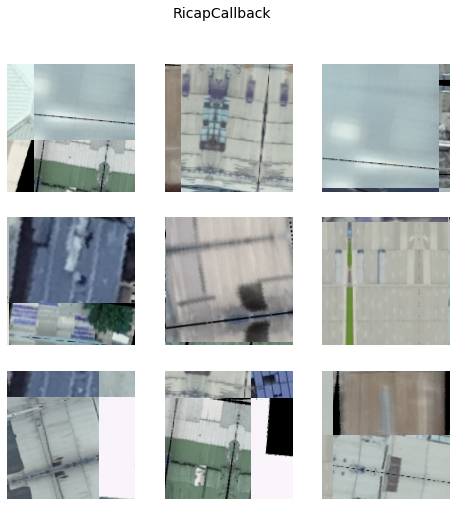

Learner(data=ImageDataBunch;

Train: LabelList (18043 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
concrete_cement,irregular_metal,healthy_metal,healthy_metal,healthy_metal
Path: data/train/rotated/clipped/256;

Valid: LabelList (4510 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
irregular_metal,healthy_metal,healthy_metal,irregular_metal,healthy_metal
Path: data/train/rotated/clipped/256;

Test: LabelList (0 items)
x: ImageList

y: EmptyLabelList

Path: data/train/rotated/clipped/256, model=Sequential(
  (0): Sequential(
    (0): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2,

In [41]:
learn.show_tfms()

We use the LR Finder to pick a good learning rate.

### Train model

In [42]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


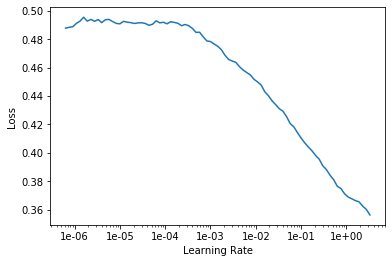

In [43]:
learn.recorder.plot()

Then we can fit the head of our network.

In [47]:
lr = 1e-2

In [48]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,error_rate,time
0,0.204929,0.548628,0.181375,02:05
1,0.175007,0.474643,0.165410,02:06
2,0.167701,0.455440,0.153880,02:06
3,0.157695,0.430057,0.143459,02:05
4,0.155699,0.429368,0.146785,02:06


In [37]:
learn.save(f'stage-1-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}')
#saves in parent of models directory
#learn.export()

#### Load model

In [38]:
learn.load(f'stage-1-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}')

Learner(data=ImageDataBunch;

Train: LabelList (18043 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
concrete_cement,irregular_metal,healthy_metal,healthy_metal,healthy_metal
Path: data/train/rotated/clipped/256;

Valid: LabelList (4510 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
irregular_metal,healthy_metal,healthy_metal,irregular_metal,healthy_metal
Path: data/train/rotated/clipped/256;

Test: LabelList (0 items)
x: ImageList

y: EmptyLabelList

Path: data/train/rotated/clipped/256, model=Sequential(
  (0): Sequential(
    (0): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2,

In [38]:
interp = ClassificationInterpretation.from_learner(learn)
interp.most_confused(min_val=2)

[('irregular_metal', 'healthy_metal', 250),
 ('healthy_metal', 'irregular_metal', 107),
 ('incomplete', 'irregular_metal', 84),
 ('concrete_cement', 'healthy_metal', 40),
 ('other', 'healthy_metal', 35),
 ('incomplete', 'healthy_metal', 17),
 ('healthy_metal', 'concrete_cement', 15),
 ('irregular_metal', 'concrete_cement', 15),
 ('incomplete', 'concrete_cement', 13),
 ('irregular_metal', 'incomplete', 13),
 ('concrete_cement', 'irregular_metal', 12),
 ('other', 'irregular_metal', 12),
 ('concrete_cement', 'incomplete', 8),
 ('healthy_metal', 'incomplete', 4),
 ('irregular_metal', 'other', 2),
 ('other', 'concrete_cement', 2)]

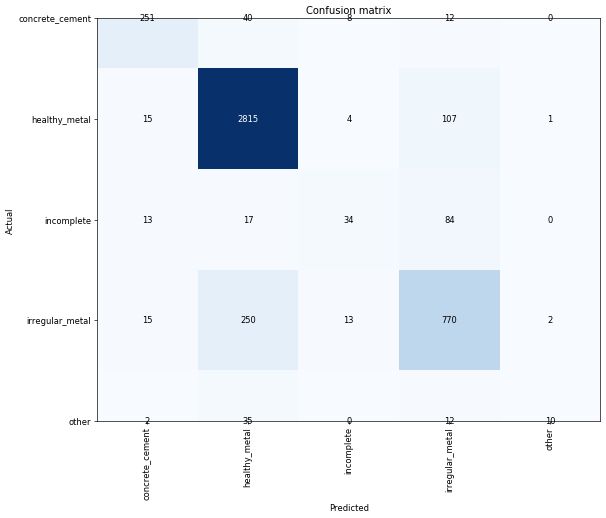

In [39]:
interp.plot_confusion_matrix(figsize=(10,10), dpi=60)

### Re-train

In [40]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


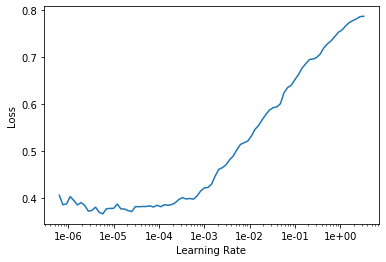

In [41]:
learn.lr_find()
learn.recorder.plot()

In [42]:
learn.fit_one_cycle(5, slice(1e-6, lr/5))

epoch,train_loss,valid_loss,error_rate,time
0,0.413617,0.382198,0.136142,03:02
1,0.383140,0.382541,0.139246,03:03
2,0.383270,0.378893,0.134812,03:03
3,0.363174,0.375814,0.135033,03:02
4,0.356773,0.377995,0.136364,03:02


In [43]:
learn.save(f'stage-2-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}')

In [74]:
learn.load(f'stage-2-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}')

Learner(data=ImageDataBunch;

Train: LabelList (18043 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
concrete_cement,irregular_metal,healthy_metal,healthy_metal,healthy_metal
Path: data/train/rotated/clipped/256;

Valid: LabelList (4510 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
irregular_metal,healthy_metal,healthy_metal,irregular_metal,healthy_metal
Path: data/train/rotated/clipped/256;

Test: LabelList (0 items)
x: ImageList

y: EmptyLabelList

Path: data/train/rotated/clipped/256, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    

In [44]:
learn.fit_one_cycle(5, slice(1e-6, lr/5))

epoch,train_loss,valid_loss,error_rate,time
0,0.335600,0.383017,0.135477,03:00
1,0.340839,0.375140,0.134812,03:05
2,0.350321,0.382873,0.134590,03:02
3,0.319885,0.382939,0.135698,02:40
4,0.301481,0.383617,0.136364,02:26


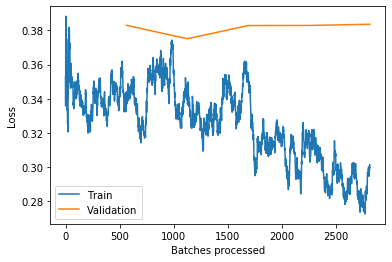

In [45]:
learn.recorder.plot_losses()

In [46]:
learn.save(f'stage-2b-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}')

### Load model and export for inference

In [32]:
learn.load(f'stage-2b-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}')


Learner(data=ImageDataBunch;

Train: LabelList (18043 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
concrete_cement,irregular_metal,healthy_metal,healthy_metal,healthy_metal
Path: data/train/rotated/clipped/256;

Valid: LabelList (4510 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
irregular_metal,healthy_metal,healthy_metal,irregular_metal,healthy_metal
Path: data/train/rotated/clipped/256;

Test: LabelList (0 items)
x: ImageList

y: EmptyLabelList

Path: data/train/rotated/clipped/256, model=Sequential(
  (0): Sequential(
    (0): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2,

In [33]:
learn = learn.to_fp32()

In [34]:
learn.export()

### Larger size images

In [45]:
data = (src.transform(tfms, size=256)
        .databunch().normalize(imagenet_stats))

learn.data = data
data.train_ds[0][0].shape

torch.Size([3, 512, 512])

In [46]:
learn.freeze()

In [47]:
learn.lr_find()
learn.recorder.plot()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


RuntimeError: CUDA out of memory. Tried to allocate 1024.00 MiB (GPU 0; 10.73 GiB total capacity; 8.32 GiB already allocated; 940.06 MiB free; 621.31 MiB cached)

In [ ]:
lr=1e-2/2

In [ ]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta
1,0.087761,0.085013,0.958006,0.926066
2,0.087641,0.083732,0.958260,0.927459
3,0.084250,0.082856,0.958485,0.928200
4,0.082347,0.081470,0.960091,0.929166
5,0.078463,0.080984,0.959249,0.930089


In [ ]:
learn.save(f'stage-1-256-{arch_name}-{MODEL_NAME}-{DATE}-{UID}')

In [ ]:
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta
1,0.082938,0.083548,0.957846,0.927756
2,0.086312,0.084802,0.958718,0.925416
3,0.084824,0.082339,0.959975,0.930054
4,0.078784,0.081425,0.959983,0.929634
5,0.074530,0.080791,0.960426,0.931257


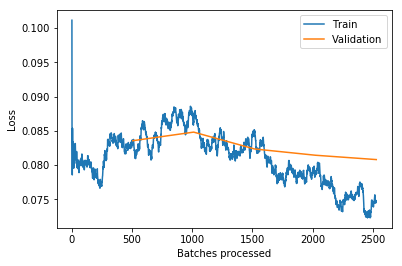

In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn.save(f'stage-2-256-{arch_name}-{MODEL_NAME}-{DATE}-{UID})

You won't really know how you're going until you submit to Kaggle, since the leaderboard isn't using the same subset as we have for training. But as a guide, 50th place (out of 938 teams) on the private leaderboard was a score of `0.930`.

In [ ]:
learn.export()

### inference

In [38]:
test_dataset=ImageList.from_folder(test_images)

In [39]:
learn = load_learner(path=data_dir/f'train/rotated/clipped/{img_size}', test=test_dataset)

In [40]:
learn.data.loss_func

FlattenedLoss of CrossEntropyLoss()

In [41]:
type(learn.data)

fastai.vision.data.ImageDataBunch

In [42]:
type(learn.dl(DatasetType.Test))

fastai.basic_data.DeviceDataLoader

Get number of items in the Valid dataset (in DeviceDataLoader)

In [43]:
len(learn.dl(DatasetType.Test).dl)

240

Required format:
    
<pre>
id	concrete_cement	healthy_metal	incomplete	irregular_metal	other
7a4d630a	0.9	0	0	0	0
7a4bbbd6	0.9	0	0	0	0
7a4ac744	0.9	0	0	0	0
7a4881fa	0.9	0	0	0	0
7a4aa4a8	0.9	0	0	0	0
</pre>


In [44]:
preds,y= learn.get_preds(ds_type=DatasetType.Test)

In [45]:
labels = np.argmax(preds, 1)

In [46]:
len(preds)

15325

In [47]:
preds[0].tolist()

[0.5483151078224182,
 0.4485120177268982,
 0.0014102827990427613,
 0.0011081080883741379,
 0.0006545081268996]

In [48]:
preds_list=[]
for pred in preds:
    preds_list.append(pred.tolist())

In [49]:
len(labels)

15325

In [50]:
learn.data.classes

['concrete_cement', 'healthy_metal', 'incomplete', 'irregular_metal', 'other']

In [51]:
data.classes

['concrete_cement', 'healthy_metal', 'incomplete', 'irregular_metal', 'other']

In [52]:
test_predictions = [learn.data.classes[int(x)] for x in labels]

In [53]:
test_predictions[0]

'concrete_cement'

In [54]:
type(learn.data.test_ds)

fastai.data_block.LabelList

In [55]:
 learn.data.test_ds.x.items

array([PosixPath('data/test/rotated/clipped/256/7a4d9168.tif'),
       PosixPath('data/test/rotated/clipped/256/7a4ae922.tif'),
       PosixPath('data/test/rotated/clipped/256/7a48ca98.tif'),
       PosixPath('data/test/rotated/clipped/256/7a49c614.tif'), ...,
       PosixPath('data/test/rotated/clipped/256/sharp_t100/7a468774.tif'),
       PosixPath('data/test/rotated/clipped/256/sharp_t100/7a4b7946.tif'),
       PosixPath('data/test/rotated/clipped/256/sharp_t100/7a4e81f4.tif'),
       PosixPath('data/test/rotated/clipped/256/sharp_t100/7a501f50.tif')], dtype=object)

In [56]:
ids=[]
for item in learn.data.test_ds.x.items:
    base, id = os.path.split(item)
    id = id.split('.tif')[0]
    ids.append(id)

In [57]:
preds_list[0]

[0.5483151078224182,
 0.4485120177268982,
 0.0014102827990427613,
 0.0011081080883741379,
 0.0006545081268996]

In [58]:
cols = learn.data.classes.copy()
cols.insert(0,'id')
df = pd.DataFrame(list(zip(ids, preds_list)), 
               columns =['id', 'pred']) 

In [59]:
cols

['id',
 'concrete_cement',
 'healthy_metal',
 'incomplete',
 'irregular_metal',
 'other']

In [60]:
df.head()

,id,pred
0,7a4d9168,"[0.5483151078224182, 0.4485120177268982, 0.001..."
1,7a4ae922,"[0.003029676154255867, 0.9789470434188843, 0.0..."
2,7a48ca98,"[0.0016933908918872476, 0.11083970963954926, 0..."
3,7a49c614,"[0.0027845362201333046, 0.8177614808082581, 0...."
4,7a4dd4f2,"[0.005415217485278845, 0.7761266827583313, 0.0..."


In [61]:
pred_df = pd.DataFrame(df['pred'].values.tolist())

In [62]:
pred_df.insert(loc=0, column='id', value=ids)

In [63]:
pred_df.columns = cols

In [64]:
pred_df.head()

,id,concrete_cement,healthy_metal,incomplete,irregular_metal,other
0,7a4d9168,0.548315,0.448512,0.001410,0.001108,0.000655
1,7a4ae922,0.003030,0.978947,0.001235,0.016447,0.000342
2,7a48ca98,0.001693,0.110840,0.008839,0.877098,0.001530
3,7a49c614,0.002785,0.817761,0.001458,0.176358,0.001638
4,7a4dd4f2,0.005415,0.776127,0.003827,0.184290,0.030341


In [65]:
pred_ids=pred_df['id'].values.tolist()

In [66]:
df_baseline = pd.read_csv(data_dir/f'submissions/mean_baseline.csv')

In [67]:
baseline_ids=df_baseline['id'].values.tolist()

In [68]:
pred_df['id_cat'] = pd.Categorical(
    pred_df['id'], 
    categories=baseline_ids, 
    ordered=True
)

In [69]:
pred_df=pred_df.sort_values('id_cat')

In [70]:
pred_df.drop(columns=['id_cat'],inplace=True)

In [71]:
pred_df=pred_df.drop_duplicates(subset=['id'])

In [72]:
pred_df.to_csv(data_dir/f'submissions/stage-2-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}.csv', index=False)

#### Submission result

sub 8: 0.4947 

In [74]:
pred_df=pd.read_csv(data_dir/f'submissions/stage-2-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}.csv')

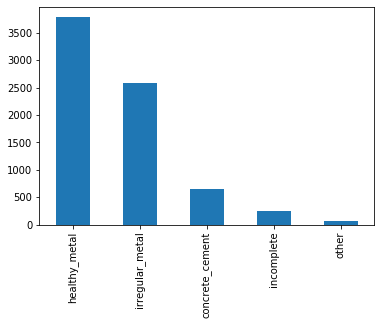

In [75]:
pred_df.drop(columns=['id'],inplace=True)
classes=pred_df.idxmax(axis=1)
pd.value_counts(classes).plot(kind="bar")